Imports

In [15]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import cdist
from scipy.linalg import pinv
from sklearn.metrics import mean_squared_error

import os
import pickle

import importlib
import src
importlib.reload(src)


Python random seed set.
NumPy random seed set.


<module 'src' from '/Users/hugojohnson/Desktop/Deep Learning/02456-deep-learning-project/src/__init__.py'>

Load data

In [16]:
X_train, X_test, y_train, y_test, scaler_X, scaler_y = src.dataset.load_split_data()

# Convert to 3D-format for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_test = scaler_y.inverse_transform(y_test) # This must be run once otherwise it will un-normalise it twice!
# print(X_train.shape)
# print(X_train)

Loaded from pickle


Model setup

In [17]:
sigma = 100
num_centers = 10
class RBFNetwork:
    def __init__(self, centers, sigma):
        self.centers = centers.reshape(-1, centers.shape[-1])
        self.sigma = sigma
        self.weights = None # Set later

    def _rbf(self, X):
        distances = cdist(X, self.centers, 'euclidean')
        return np.exp(-distances ** 2 / (2 * self.sigma ** 2))  # Gaussian RBF
        # return 1 / np.sqrt(distances ** 2 + self.sigma ** 2)  # Inverse Multiquadratic RBF

    def fit(self, X, y):
        G = self._rbf(X)
        self.weights = pinv(G).dot(y) # Pseudo inverse to solve in one step (instead of gradient descent)

    def predict(self, X):
        G = self._rbf(X)
        return G.dot(self.weights)


random_indices = np.random.choice(X_train.shape[0], num_centers, replace=False)
centers = X_train[random_indices, :]

rbf_net = RBFNetwork(centers, sigma=sigma)
# print(y_train[:, 0].reshape(-1, 1).shape)
# print(y_train[:, 0].reshape(-1, 1))
# print(rbf_net.centers.shape)
rbf_net.fit(X_train.reshape(-1, X_train.shape[-1]), y_train[:, 1].reshape(-1, 1)) # COLUMN 1.
# rbf_net.fit(X_train, y_train)

y_pred = rbf_net.predict(X_test.reshape(-1, X_train.shape[-1]))

# Reverse the transform
y_pred_full = np.zeros((y_pred.shape[0], 3)) # A placeholder array with 3 columns
y_pred_full[:, 0] = y_pred.flatten()
y_pred = scaler_y.inverse_transform(y_pred_full)[:, 0]

# Beregn MSE
mse = mean_squared_error(y_test[:, 0].reshape(-1, 1), y_pred)
print("Mean Squared Error of test data:", mse)

Mean Squared Error of test data: 1399.5962804877454


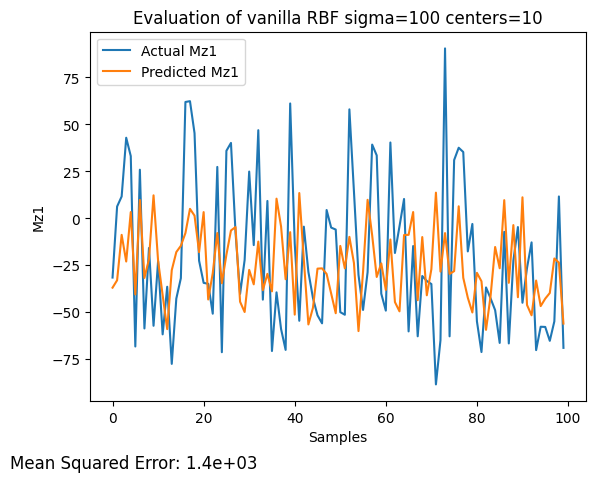

In [18]:
src.plots.evaluate_predictions(y_pred[:100], y_test[:, 0][:100], mse, name=f"vanilla RBF sigma={sigma} centers={num_centers}")